# Medical Insurance Dataset Analysis
---
### William Hayward

The goal of this notebook is to perform some exploratory data analysis on this sample dataset from Kaggle (by user Mosap Abdel-Ghany). Here I will look to find any patterns, trends, or short-comings in this dataset, with the overall goal of modelling the charges accumulated by a given person based on these parameters, and producing some machine learning models.

In [1]:
# Import standard data science libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ipympl

from sklearn.model_selection import train_test_split
from sklearn import tree

import torch

sns.set(style = "darkgrid")

In [2]:
# Read in csv file
df = pd.read_csv(r"insurance.csv").sort_values("smoker", ascending = True)

# First look at dataset
display(df.head())

print("\n")

# Basic summary info
display(df.describe())

print("\n")

# Check for nulls
print(df.info())

,age,sex,bmi,children,smoker,region,charges
556,46,male,33.440,1,no,northeast,8334.58960
724,50,female,27.075,1,no,northeast,10106.13425
1197,41,male,33.550,0,no,southeast,5699.83750
726,41,male,28.405,1,no,northwest,6664.68595
728,18,female,40.280,0,no,northeast,2217.60120


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010




<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 556 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB
None


From inital inspection, there are no missing values or nulls in the dataset, so no replacement or filling will be required here.
To start, we will look at the distribution of the fields in the dataset, to see if there exists any outliers.

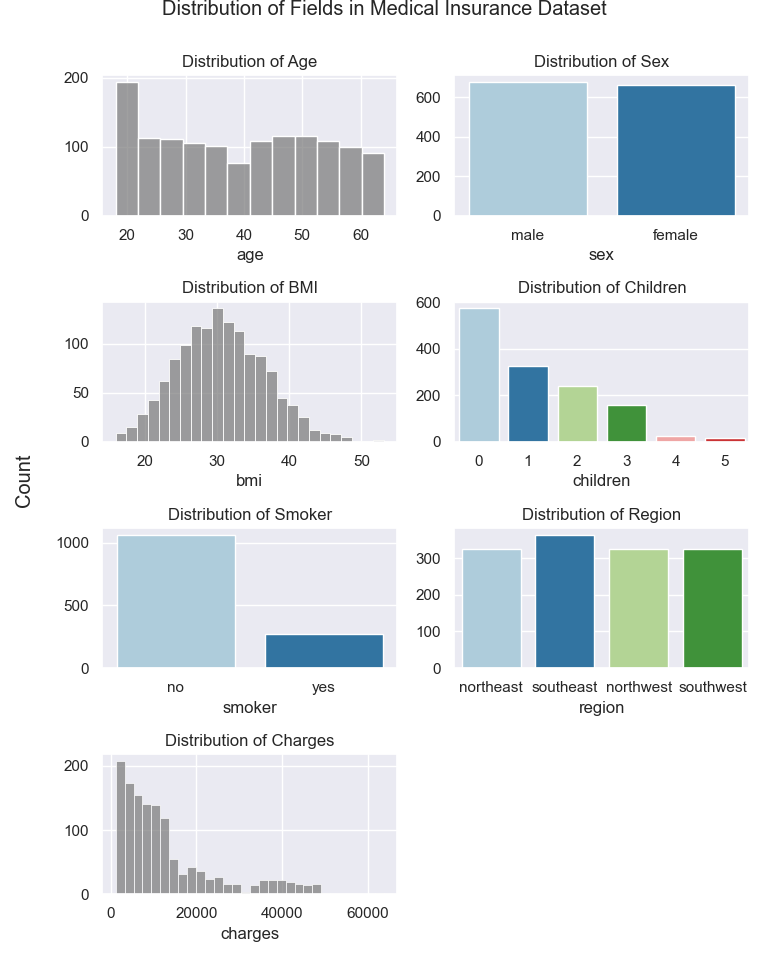

In [3]:
# First we do some EDA and see the distribution of the data

fig1, axes1 = plt.subplots(math.ceil(len(df.columns)/2), 2)

palette = "Paired"

# Remove extra plot for odd number of columns
if len(df.columns)%2 == 1:
    fig1.delaxes(axes1[-1,-1])

fig1.suptitle("Distribution of Fields in Medical Insurance Dataset", y = 1)
fig1.supylabel("Count")

for i, field in enumerate(df.columns):

    # Histplot for wider range numerical values
    if field in ["age", "bmi", "charges"]:
        sns.histplot(x = field, data = df, ax = axes1[i//2,i%2], color = "grey")
    # Countplot for categorical data or numerical with only a few values
    else:
        sns.countplot(x = field, data = df, ax = axes1[i//2,i%2], hue = field, palette = palette, legend = False)

    # Titles and axes labels for plots
    if field == "bmi":
        axes1[i//2,i%2].set_title(f"Distribution of {field.upper()}")
    else:
        axes1[i//2,i%2].set_title(f"Distribution of {field.capitalize()}")
    axes1[i//2,i%2].set_ylabel("")

# Layout of subplots
fig1.set_figheight(fig1.get_figheight()*2)
fig1.set_figwidth(fig1.get_figwidth()*1.2)
fig1.tight_layout()
plt.show()

There seems to be no obvious outliers in any of the distributions above. It is good to note that the BMI varaible seems to have a normal distribution, age a (nearly) uniform distribution, and children and charges a logarithmic distribution. This suggests the later trained model may struggle to predict higher values due to the devreasing frequence and samples - we may need to bootstrap the data and train multiple models to counteract this.

Next we look at some scatter and grouped bar plots to see the relation between each field and the target 'charges' variable. Note: After first plots, I identified that smoking had a clear impact on the charges values, so I found it more informative to plot smokers and non-smokers in different colours.

C:\Users\Willi\AppData\Local\Temp\ipykernel_12232\2479073280.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = field, y = "charges", data = data, ax = axes2[i//2, i%2], palette = palette)


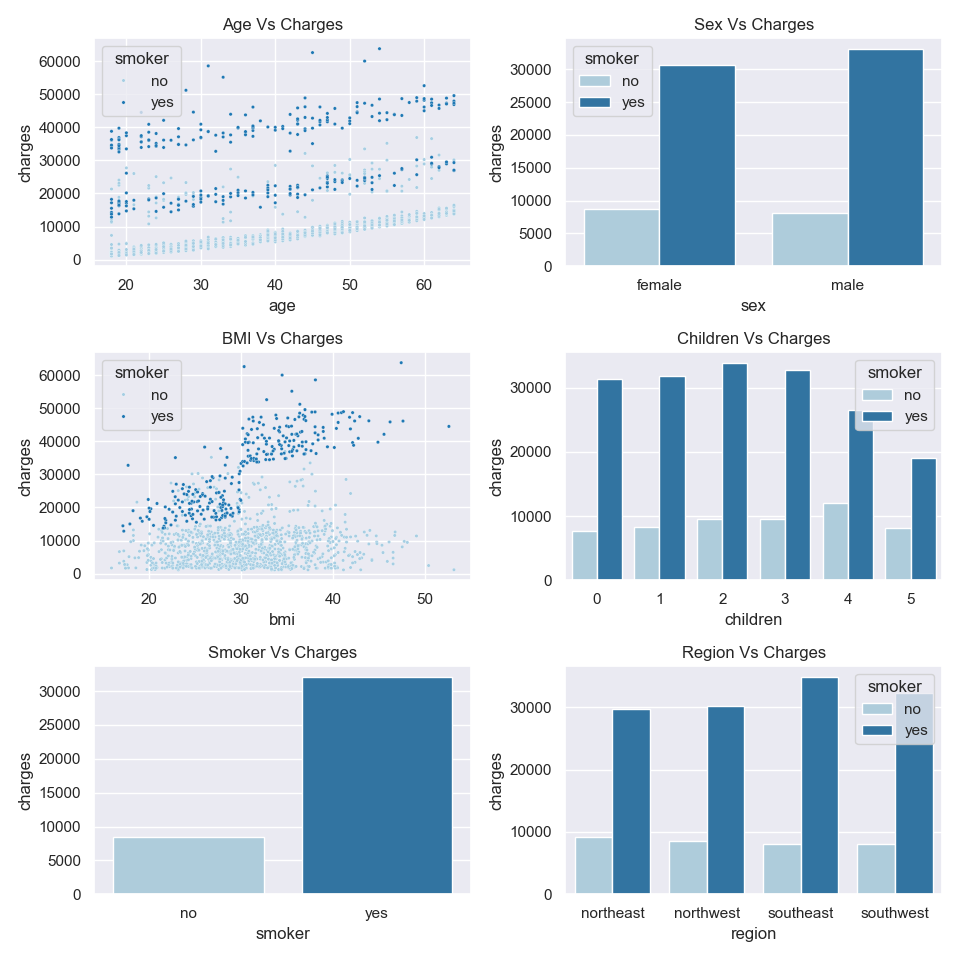

In [4]:
fig2, axes2 = plt.subplots(math.ceil((len(df.columns)-1)/2), 2)

# Remove extra plot for odd number of columns
if (len(df.columns)-1)%2 == 1:
    fig2.delaxes(axes2[-1,-1])

for i, field in enumerate(df.columns.drop(["charges"])):

    if field in ["age", "bmi"]:
        sns.scatterplot(x= field, y = "charges", data = df, ax = axes2[i//2, i%2], marker = "o", s = 6, hue = "smoker", palette = palette)
    
    elif field == "smoker":
        data = df.groupby(field)["charges"].mean().reset_index()
        sns.barplot(x = field, y = "charges", data = data, ax = axes2[i//2, i%2], palette = palette)
    else:
        data = df.groupby([field, "smoker"])["charges"].mean().reset_index()
        sns.barplot(x = field, y = "charges", data = data, ax = axes2[i//2, i%2], hue = "smoker", palette = palette)

    axes2[i//2,i%2].set_title(f"{field.capitalize() if field != "bmi" else field.upper()} Vs Charges")

fig2.set_figheight(fig2.get_figheight()*2)
fig2.set_figwidth(fig2.get_figwidth()*1.5)
fig2.tight_layout()
plt.show()

In [5]:
pcorr = df[["age","bmi","charges"]].corr()
pcorr_smoker = df[df["smoker"] == "yes"][["age","bmi","charges"]].corr()
pcorr_nonsmoker = df[df["smoker"] == "no"][["age","bmi","charges"]].corr()
scorr = df[["age","bmi","charges"]].corr("spearman")
scorr_smoker = df[df["smoker"] == "yes"][["age","bmi","charges"]].corr("spearman")
scorr_nonsmoker = df[df["smoker"] == "no"][["age","bmi","charges"]].corr("spearman")

fig3, axes3 = plt.subplots(2,3)

sns.heatmap(pcorr, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[0,0])
sns.heatmap(pcorr_smoker, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[0,1])
sns.heatmap(pcorr_nonsmoker, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[0,2])
sns.heatmap(scorr, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[1,0])
sns.heatmap(scorr_smoker, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[1,1])
sns.heatmap(scorr_nonsmoker, annot = True, fmt = ".2f", cmap = "RdYlGn", ax=axes3[1,2])

axes3[0,0].set_title("All")
axes3[0,1].set_title("Smokers")
axes3[0,2].set_title("Non-Smokers")
axes3[0,0].set_ylabel("Pearsons", rotation = 0, size = "large", labelpad = 40)
axes3[1,0].set_ylabel("Spearmans", rotation = 0, size = "large", labelpad = 40)

fig3.set_figwidth(fig3.get_figwidth()*1.5)
fig3.tight_layout()


In [6]:
df["smoker"] = df["smoker"].apply(lambda x: x == "yes")
df["sex"] = df["sex"].apply(lambda x: x == "female")

# One-Hot encode the region variable
df = pd.get_dummies(df, columns = ["region"])

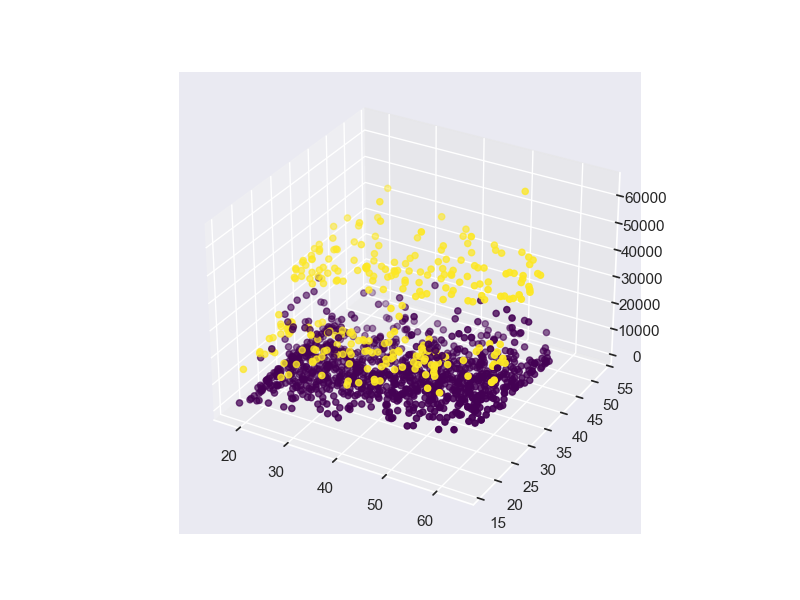

In [7]:
%matplotlib ipympl

fig4 = plt.figure(figsize=(8,6))
axes4 = fig4.add_subplot(111,projection="3d")
axes4.scatter3D(df["age"], df["bmi"], df["charges"], c=df["smoker"], cmap="viridis")
plt.show()

In [8]:
data = df.drop(columns="charges").copy().to_numpy()
values = df["charges"].copy().to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, values, test_size = 0.2)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1070, 9) (1070,) (268, 9) (268,)


In [9]:
tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [10]:
predictions = tree_model.predict(X_test)
SE = (predictions - y_test)**2
MSE = sum(SE)/len(SE)

In [11]:
MSE

np.float64(42628556.894353)